In [1]:
import numpy as np
from PIL import Image
from math import log2
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

### Convolution function with padding , stride and non linear function  

In [2]:
#function that takes care of relection padding of the give image on all the edges
def padding(kernel_size,image):
    W,H=image.shape
    pad_size=kernel_size-1   #number of layers of pad
    padded_image=[[0]*(W+2*(kernel_size-1))]*(H+2*(kernel_size-1))
    padded_image=np.asarray(padded_image)
    padded_image[pad_size:pad_size+W, pad_size:pad_size+H] = image

    #row padding
    for i in range(pad_size):
        padded_image[i,pad_size:pad_size+H]=image[pad_size-1-i]  
        padded_image[W+2*kernel_size-2-(i+1),pad_size:pad_size+H] = image[W-(pad_size-i)]
    #column padding
    for j in range(pad_size):
        padded_image[:,j]=padded_image[:,2*pad_size-(j+1)]
        padded_image[:,(H+2*kernel_size-2)-(j+1)]=padded_image[:,(H+2*kernel_size-2)-(2*pad_size-j)]
        
    return padded_image

In [3]:
#non linear functions
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(x,0)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def softmax(x):
    y = np.empty(x.shape)
    for i in range(0,np.shape(x)[0]):
        y[i] = (np.exp(x[i])/np.sum(np.exp(x)))
    return y

def Prelu(x,a):
    if(x>0):
        return x
    else:
        return a*x

In [4]:
#Convolution function that convolves image with kernel
def convolution(image,kernel,stride,pad, non_linear_func):
    if(pad == 1 ):
        J=padding(kernel.shape[0],image)
    else:
        J=image
    kernel = np.flipud(np.fliplr(kernel))                        #flipping the kernel
    padded_r,padded_c = J.shape
    kernel_r,kernel_c = kernel.shape
    conv_r,conv_c = padded_r-kernel_r+1,padded_c-kernel_c+1
    conv_img=np.zeros([conv_r,conv_c])
    
    for i in range(conv_r):
        for j in range(conv_c):
            s = 0
            for p in range(kernel_r):
                for q in range(kernel_c):
                    s += J[i+p][j+q] * kernel[p][q]               ####convolution formula
            conv_img[i][j] = s
            i = i+stride-1
        j = j+stride-1
        
    if non_linear_func == "sigmoid":
        conv_img = sigmoid(conv_img)
    if non_linear_func == "relu":
        conv_img = relu(conv_img)
    if non_linear_func == "Prelu":
        conv_img = Prelu(conv_img,0.001)
    if non_linear_func == "tanh":
        conv_img = tanh(conv_img)

    return conv_img

In [5]:
#read the image 
Img = img.imread('4.1.01.tiff')
W,H,C=Img.shape
display_img=Img
Img=Img.transpose(2, 0, 1)

In [6]:
#generate a kernel
x = [[1,2,1],[2,4,2],[1,1,1]]
KERNEL = np.stack((x,x,x),2)/16
k=KERNEL.shape[0]

#### With padding 

The original image


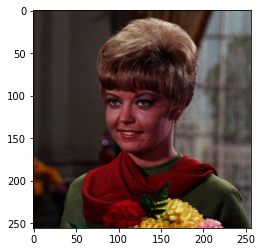

In [7]:
print("The original image")
plt.imshow(display_img)

In [8]:
print(f"The kernel used is {KERNEL}")

The kernel used is [[[0.0625 0.0625 0.0625]
  [0.125  0.125  0.125 ]
  [0.0625 0.0625 0.0625]]

 [[0.125  0.125  0.125 ]
  [0.25   0.25   0.25  ]
  [0.125  0.125  0.125 ]]

 [[0.0625 0.0625 0.0625]
  [0.0625 0.0625 0.0625]
  [0.0625 0.0625 0.0625]]]


##### Sigmoid 

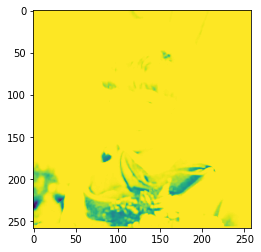

In [9]:
#padding =1  (bool value)
output = convolution(Img[0], KERNEL[0],0, 1, "sigmoid") + convolution(Img[1], KERNEL[1],0, 1, "sigmoid")+ convolution(Img[2], KERNEL[2],0, 1, "sigmoid")
plt.imshow(output)

#### tanh 

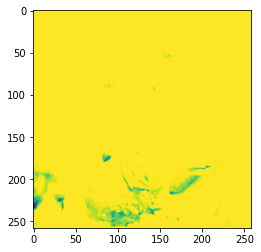

In [10]:
#padding =1 
output = convolution(Img[0], KERNEL[0],0, 1, "tanh") + convolution(Img[1], KERNEL[1],0, 1, "tanh")+ convolution(Img[2], KERNEL[2],0, 1, "tanh")
plt.imshow(output)

#### Relu 

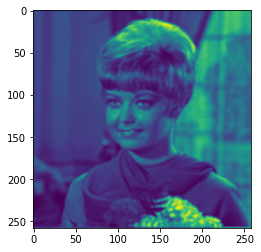

In [11]:
#padding =1 
output = convolution(Img[0], KERNEL[0],0, 1, "relu") + convolution(Img[1], KERNEL[1],0, 1, "relu")+ convolution(Img[2], KERNEL[2],0, 1, "relu")
plt.imshow(output)

#### Parametric ReLU

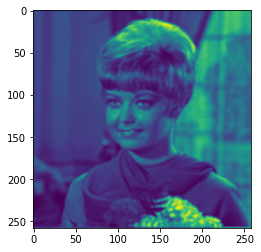

In [12]:
#padding =1 
output = convolution(Img[0], KERNEL[0],0, 1, "prelu") + convolution(Img[1], KERNEL[1],0, 1, "prelu")+ convolution(Img[2], KERNEL[2],0, 1, "prelu")
plt.imshow(output)

### pooling function  

In [13]:
#max pool the convolved image
def max_pool(conv_image,stride):
    W,H=conv_image.shape
    mp_R =int((W-2)/stride+1)
    mp_C= int((H-2)/stride+1)
    mp_output = np.empty([mp_R,mp_C])
    x=0
    y=0
    for i in range(0,mp_R):
        for j in range(0,mp_C):
            temp = np.array([[conv_image[i][j],conv_image[i][j+1]],[conv_image[i+1][j],conv_image[i+1][j+1]]])
            mp_output[x][y] = np.amax(temp)
            y=y+1
            j = j + stride - 1
        y = 0
        x+=1
        i = i + stride - 1
    return mp_output

#avg pool the convolved image
def avg_pool(conv_image,stride):
    W,H=conv_image.shape
    avg_R=W-(2-1)*stride
    avg_C=H-(2-1)*stride
    avg = np.empty([avg_R,avg_C])
    x=0
    y=0
    for i in range(avg_R):
        for j in range(avg_C):
            temp = np.array([[conv_image[i][j],conv_image[i][j+1]],[conv_image[i+1][j],conv_image[i+1][j+1]]])
            avg[x][y] = np.sum(temp)/4
            y=y+1
            j = j + stride - 1
        y = 0
        x+=1
        i = i + stride - 1
    return avg


In [14]:
def pooling(conv_output,pool_func,stride): #pooling from 2x2 matrices
    if pool_func == "max":
        result=max_pool(conv_output,stride)
    if pool_func == "avg":
        result = avg_pool(conv_output,stride)
    return result

input image to the pooling function


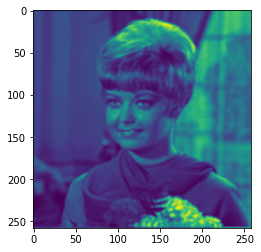

In [15]:
print("input image to the pooling function")
plt.imshow(output)

#### max pooling 

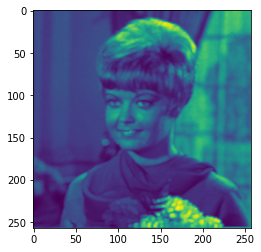

In [16]:
plt.imshow(pooling(output,"max",1))

#### Avg pooling

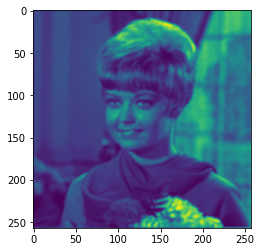

In [17]:
plt.imshow(pooling(output,"avg",1))

### Convoution layer function 

In [18]:
#function to generate kernels of given size and count
def generateKernel(no_kernels, c2):
    kernel = np.empty([no_kernels,3,3,c2])
    for i in range (0,np.shape(kernel)[0]):
        kernel[i] = np.random.rand(np.shape(kernel)[1],np.shape(kernel)[2],c2)
    return kernel

In [19]:
def convlayer(image, kernel, stride, padding, non_linear_func):
    if(padding==1):
        pad=kernel[0].shape[0]-1
    else :
        pad=0
    c,W,H=image.shape
    m=W+2*(pad)
    n=H+2*(pad)
    rows = m-(kernel[0].shape[0]-1)
    cols= n-(kernel[0].shape[1]-1)
    result = np.zeros([np.shape(kernel)[0],rows,cols])
    for i in range (0,np.shape(kernel)[0]):
        kernel_temp=kernel[i]
        kernel_temp=kernel_temp.transpose(2,0,1)
        for j in range(kernel_temp.shape[0]):
            result[i]+=convolution(image[j],kernel_temp[j],stride, padding,non_linear_func)
    print (f"Size = {result.shape}")
    return result

[[[[0.33225825 0.31608127 0.21118372]
   [0.30958033 0.79812274 0.7848766 ]
   [0.4188288  0.39574418 0.70710495]]

  [[0.01067464 0.75091277 0.84836517]
   [0.31965863 0.03242467 0.35622757]
   [0.99349206 0.57422574 0.30307195]]

  [[0.05793839 0.44157324 0.97348653]
   [0.51619011 0.11491524 0.2025993 ]
   [0.84211952 0.19618009 0.40522802]]]


 [[[0.27846856 0.41133011 0.39548044]
   [0.4085615  0.17004169 0.11298556]
   [0.0089633  0.68259266 0.6424471 ]]

  [[0.25982665 0.08296198 0.70326729]
   [0.24487322 0.94724422 0.4996194 ]
   [0.1712846  0.07769019 0.61623537]]

  [[0.01772089 0.49102967 0.3841354 ]
   [0.53967317 0.98240341 0.76567496]
   [0.92253796 0.88489637 0.96956318]]]


 [[[0.44133094 0.67139114 0.88981171]
   [0.84213174 0.81805355 0.62705695]
   [0.78130679 0.7064174  0.40792997]]

  [[0.57944818 0.85204903 0.76288989]
   [0.94390759 0.63495389 0.81505523]
   [0.22642588 0.74333079 0.5103261 ]]

  [[0.44064057 0.60197031 0.86665243]
   [0.44709959 0.71579586 0.50

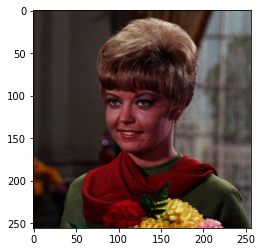

In [20]:
KERNEL_CVL = generateKernel(3,3)
plt.imshow(display_img)
print(KERNEL_CVL)

Size = (3, 258, 258)


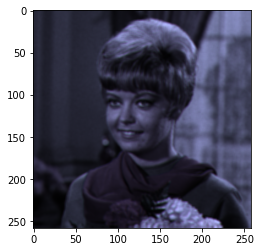

In [21]:
cvl_output = convlayer(Img, KERNEL_CVL, 1, 1, "relu")
cvl_output=cvl_output.transpose(1,2,0)
cvl_output = cvl_output/np.amax(cvl_output)
cvl_output = np.clip(cvl_output, 0, 1)
plt.imshow(cvl_output)

Since the image is padded with 2 layers the size of the image is 3 X 258 X 258 where the 3 is equal to the number of kernels I have used to convolve the given image.

### pooling layer function 

In [22]:
def pool_layer(image,pool_func,stride):
    W,H,c=image.shape
    image=image.transpose(2,0,1)
    mp_R =int((W-2)/stride+1)
    mp_C= int((H-2)/stride+1)
    result = np.empty([c,mp_R,mp_C])
    for i in range(0,np.shape(image)[0]):
        result[i] = pooling(image[i],pool_func,stride)
    return result



#### max pooling 

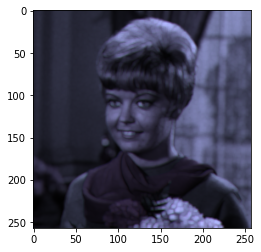

In [23]:
pool_output=pool_layer(cvl_output,"max",1)
pool_output=pool_output.transpose(1,2,0)
plt.imshow(pool_output)

#### avg pooling 

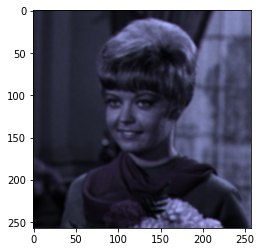

In [24]:
pool_output=pool_layer(cvl_output,"avg",1)
pool_output=pool_output.transpose(1,2,0)
plt.imshow(pool_output)

### flattening function 

In [25]:
def flatten(pool_out,Weight,bias):
    W,C,H = pool_out.shape
    pool_out= pool_out.reshape(W*H*C,1)
    result = np.matmul(Weight,pool_out)+bias
    return result

In [26]:
W,C,H= pool_output.shape
Weight = np.random.rand(100,W*H*C)
bias = np.random.rand(100,1)

In [27]:
flatten_output=flatten(pool_output,Weight,bias)
flatten_output.shape

(100, 1)

### MLP function 

In [28]:
def mlp_func(vec,hiddden_layers,each_hl_size,non_linear_func,size_output,Weight,bias):
    for i in range(0,1):
        if non_linear_func == "sigmoid":
            vec = sigmoid(vec)
        if non_linear_func == "relu":
            vec = relu(vec)
        if non_linear_func == "tanh":
            vec = tanh(vec)
    mlp_out = np.matmul(vec.T,Weight)+bias
    return mlp_out 

In [29]:
Weight2 = np.random.rand(np.shape(flatten_output)[0],10)
bias2 = np.random.rand(1,10)

#### mlp output without softmax 

In [30]:
mlp_output=mlp_func(flatten_output,10,np.shape(flatten_output)[0],"relu",10,Weight2,bias2)
print(mlp_output.shape)

(1, 10)


#### mlp output with softmax 

In [31]:
mlp_output = mlp_output.reshape(10)
mlp_output_after_sm=softmax(mlp_output)
print(mlp_output_after_sm.shape)

(10,)


/tmp/ipykernel_48475/762913912.py:14: RuntimeWarning: overflow encountered in exp
  y[i] = (np.exp(x[i])/np.sum(np.exp(x)))
/tmp/ipykernel_48475/762913912.py:14: RuntimeWarning: invalid value encountered in double_scalars
  y[i] = (np.exp(x[i])/np.sum(np.exp(x)))


### Feed forward path 

In [32]:
def feed_forward(Img):
    W,H,C=Img.shape
    
    # Convolution no of kernels=16 size=3x3x3
    kernel_16=generateKernel(16,3)   
    cvl_output = convlayer(Img,kernel_16,1, 1, "sigmoid")
    cvl_output=cvl_output.transpose(1,2,0)
    cvl_output = cvl_output/np.amax(cvl_output)
    cvl_output = np.clip(cvl_output, 0, 1)
    
    # Max-Pooling 2x2 stride=2    
    pool_output=pool_layer(cvl_output,"max",2)
    
    # Convolution no of kernels=8 3x3xc2
    c2=16                                                            # The  value of c2 is 16    
    kernel_8 = generateKernel(8,c2)
    cvl_output = convlayer(pool_output, kernel_8, 1, 1, "sigmoid")
    cvl_output=cvl_output.transpose(1,2,0)
    cvl_output = cvl_output/np.amax(cvl_output)
    cvl_output = np.clip(cvl_output, 0, 1)
    
    # Max-Pooling 2x2 stride=2
    pool_output=pool_layer(cvl_output,"max",2)
    pool_output=pool_output.transpose(1,2,0)
    
    # Flattening
    r,c,h = np.shape(pool_output)
    W1 = np.random.rand(50,r*c*h)
    b1 = np.random.rand(50,1)
    flatten_output=flatten(pool_output,W1,b1)
    
    
    # MLP 10 output
    W2 = np.random.rand(np.shape(flatten_output)[0],10)
    b2 = np.random.rand(1,10)

    mlp_output=mlp_func(flatten_output,10,np.shape(flatten_output)[0],"sigmoid",10,W2,b2)
    vector = mlp_output.reshape(10)
    print(f"final vector is {vector}")
    return vector,flatten_output

In [33]:
Img = img.imread('4.1.01.tiff')
Img=Img.transpose(2, 0, 1)
output_vector,fl=feed_forward(Img)
print(output_vector.shape)

Size = (16, 258, 258)
Size = (8, 131, 131)
final vector is [27.30638399 27.28402901 26.14333333 25.20071163 24.53998713 26.79510677
 24.30046452 27.19109818 26.45524006 27.2668648 ]
(10,)


### Question 8 

8(a)

In [34]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [35]:
dict1=unpickle("cifar-10-python/cifar-10-batches-py/data_batch_1")
labels_index=[]
#creating a list of indices of unique labels present in the data_batch1
for i in range(10):
    labels_index.append(dict1[b'labels'].index(i))

labels_index

[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]

In [36]:
image_data=[]
#for the above collected indices , append the data of the corresponding image into a list
for i in labels_index:
    image = dict1[b'data'][i].reshape(3,32,32)
#     image=image/255
    image_data.append(image)
image_data

[array([[[202, 202, 204, ..., 207, 205, 203],
         [206, 206, 207, ..., 210, 208, 206],
         [210, 211, 212, ..., 214, 212, 210],
         ...,
         [218, 210, 194, ..., 243, 244, 243],
         [219, 217, 216, ..., 241, 241, 241],
         [217, 216, 217, ..., 239, 239, 240]],
 
        [[204, 204, 206, ..., 208, 206, 204],
         [208, 208, 209, ..., 211, 209, 207],
         [212, 213, 214, ..., 214, 213, 211],
         ...,
         [217, 209, 194, ..., 242, 242, 243],
         [218, 216, 216, ..., 240, 240, 240],
         [216, 215, 216, ..., 238, 238, 238]],
 
        [[199, 199, 201, ..., 200, 199, 198],
         [203, 203, 204, ..., 205, 203, 201],
         [207, 208, 210, ..., 210, 208, 206],
         ...,
         [222, 214, 198, ..., 247, 247, 247],
         [223, 221, 220, ..., 245, 245, 245],
         [221, 220, 221, ..., 243, 243, 243]]], dtype=uint8),
 array([[[170, 168, 177, ..., 162, 158, 157],
         [168, 172, 171, ..., 159, 156, 154],
         [154, 1

In [37]:
#call feed_foward for all the 10 images collected from diff classes
for i in image_data:
    vec,fl=feed_forward(i)

Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [27.79043537 24.74306479 28.55674599 22.50781255 26.57163853 28.05513891
 22.17634624 25.76342647 24.8698772  27.9071556 ]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [23.75791975 26.22979665 28.5504075  25.92899649 26.05688745 28.86464268
 27.42377719 25.53283601 23.08555779 26.64566322]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [28.73260138 26.07231043 25.84218183 25.40984747 24.88384024 28.11730412
 29.70908619 25.45407026 22.69803959 25.19048553]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [25.9940071  26.85058656 25.08829796 25.37547615 28.15589782 26.02188612
 25.97969859 29.89076285 20.96676489 25.3781355 ]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [26.24338766 28.78375099 23.56250272 26.49362606 25.67538283 22.90401654
 23.72935303 25.75229671 27.58934408 22.63178754]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [26.34462477 25.10219514 24.78432506 26.16136718 23.752

Since we are randomly initializing the weights and the bias and not upadting anywhere (because no training is performed) it is not recommended to follow a trend

8(b)

In [38]:
keys = [0,1,2,3,4,5,6,7,8,9]
dict_labels  = {key: [] for key in keys}

In [39]:
#form a dictionary to store the 3 indices of every label
for item in keys :
    count=0
    for index, elem in enumerate(dict1[b'labels']):
        if elem == item:
            count+=1                          
            dict_labels[item].append(index)
            if(count==3):
                break
dict_labels

{0: [29, 30, 35],
 1: [4, 5, 32],
 2: [6, 13, 18],
 3: [9, 17, 21],
 4: [3, 10, 20],
 5: [27, 40, 51],
 6: [0, 19, 22],
 7: [7, 11, 12],
 8: [8, 62, 69],
 9: [1, 2, 14]}

In [40]:
#form a dictionary to store the image data of the correspinding indices of every label
dict_image_data  = {key: [] for key in keys}
for k in keys:
    v=dict_labels[k]
    dict_image_data[k].append(dict1[b'data'][v[0]].reshape(3,32,32))
    dict_image_data[k].append(dict1[b'data'][v[1]].reshape(3,32,32))
    dict_image_data[k].append(dict1[b'data'][v[2]].reshape(3,32,32))
dict_image_data 

{0: [array([[[202, 202, 204, ..., 207, 205, 203],
          [206, 206, 207, ..., 210, 208, 206],
          [210, 211, 212, ..., 214, 212, 210],
          ...,
          [218, 210, 194, ..., 243, 244, 243],
          [219, 217, 216, ..., 241, 241, 241],
          [217, 216, 217, ..., 239, 239, 240]],
  
         [[204, 204, 206, ..., 208, 206, 204],
          [208, 208, 209, ..., 211, 209, 207],
          [212, 213, 214, ..., 214, 213, 211],
          ...,
          [217, 209, 194, ..., 242, 242, 243],
          [218, 216, 216, ..., 240, 240, 240],
          [216, 215, 216, ..., 238, 238, 238]],
  
         [[199, 199, 201, ..., 200, 199, 198],
          [203, 203, 204, ..., 205, 203, 201],
          [207, 208, 210, ..., 210, 208, 206],
          ...,
          [222, 214, 198, ..., 247, 247, 247],
          [223, 221, 220, ..., 245, 245, 245],
          [221, 220, 221, ..., 243, 243, 243]]], dtype=uint8),
  array([[[126, 122, 126, ..., 124, 120, 117],
          [122, 119, 121, ..., 124,

In [41]:
#call feed forward for all the 10*3=30 images and append the result list into X for plotting
X=[]
for k in keys:
    print(k)
    v=dict_image_data[k]
    for i in v:
        temp_vec,temp_fl=feed_forward(i)
        X.append(temp_fl.flatten().tolist())
X

0
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [27.56257105 25.99934742 24.32180132 25.87985052 21.29343958 29.08793404
 27.14452958 26.97831762 26.44369153 23.47007552]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [22.1204692  23.19046534 27.11409111 22.76661268 21.21378058 22.40089282
 26.46927505 27.46866722 21.20335009 25.95728968]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [26.01732304 26.60223994 25.30598829 30.67224694 27.59631714 22.61245652
 24.75784739 24.46405653 24.96705147 24.49740096]
1
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [25.13308845 26.22672667 24.53432896 26.05259627 26.20563177 25.06292322
 23.65470307 27.71992355 25.8395154  22.54073499]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [24.40188198 26.74165922 24.92152851 26.69718569 25.31046458 25.34078497
 24.5454544  25.34046802 27.01409007 25.9406583 ]
Size = (16, 34, 34)
Size = (8, 19, 19)
final vector is [28.09511568 25.98908566 24.42703109 20.78419589 23

[[319.8517973578131,
  327.72756385270566,
  311.5974070866429,
  324.4213053712079,
  325.2618088644693,
  322.6476059032155,
  329.4013262455136,
  328.204121849682,
  330.9698100618464,
  326.0876983349701,
  317.38643250549785,
  332.8427808448735,
  332.0256775792308,
  320.1917814077363,
  319.0080278897566,
  317.6126510184034,
  316.10952319688073,
  315.51852514745497,
  325.92412879033645,
  329.7122796977124,
  316.6401472832001,
  317.8123801975513,
  325.4409098214557,
  323.16713434055697,
  320.6281257019541,
  314.9988234969856,
  329.1722766323718,
  309.83741839355554,
  315.2073672238557,
  317.7139320436312,
  312.6359620798332,
  319.4506767366118,
  323.73242662120674,
  326.06990806253,
  322.2137144198101,
  335.2351968954621,
  315.55122475294723,
  331.3871711494275,
  324.9044792473367,
  345.8570289612667,
  318.4519942156611,
  319.2448457252473,
  334.9047478721593,
  333.0357515640936,
  330.7828766813389,
  328.1277061632321,
  320.22349241660265,
  323.

In [42]:
#tsne plots
tsne = TSNE(n_components=2,perplexity=5).fit_transform(X)
tsne

/home/nisha/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nisha/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[-268.82922 ,  -42.418644],
       [ 485.00565 ,   23.290136],
       [ -62.171616,  -21.806005],
       [ -56.345413,  147.11365 ],
       [  86.995125, -268.33853 ],
       [  54.54583 ,  -70.87343 ],
       [ 320.81528 , -476.4423  ],
       [  68.61607 , -669.28357 ],
       [ 400.16864 , -278.8662  ],
       [ -19.74523 , -390.60956 ],
       [-203.49757 ,  443.70654 ],
       [ -39.623142,  462.22775 ],
       [  76.98343 ,  220.00919 ],
       [-360.9131  , -382.16528 ],
       [-434.92102 , -129.3802  ],
       [-372.72415 ,  183.292   ],
       [-207.1622  , -269.54636 ],
       [  55.935284,   66.22014 ],
       [ 244.9636  ,  257.50076 ],
       [ 282.14578 , -308.73627 ],
       [-114.27683 ,  415.7359  ],
       [-159.6829  ,   66.2975  ],
       [ 185.66536 , -165.59851 ],
       [ 224.95534 ,  100.26969 ],
       [  -5.659401, -250.73575 ],
       [-185.68088 , -170.17023 ],
       [ -88.828926,  295.21426 ],
       [ 158.99324 ,  618.3552  ],
       [ -80.78647 ,

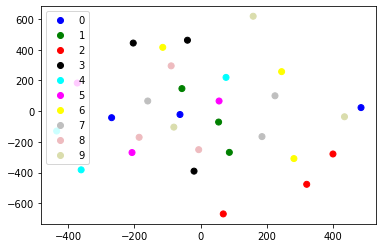

In [43]:
tx = tsne[:, 0]
ty = tsne[:, 1]
colour_list = ['blue', 'green', 'red', 'black', 'cyan', 'magenta', 'yellow','0.75', '#eebbbf', '#daddad', ]
values = []
for c in range(10):
    for i in range(3):
        values.append(c)
colours= ListedColormap(colour_list)
scatter=plt.scatter(tx,ty,marker='o',c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=keys)
plt.show()    

Yes,because each neuron is no longer doing the same calculation, a randomly started network exhibits some discriminability. This aids the network in breaking the symmetry.